In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os, pickle, time, warnings, h5py

import numpy as np, pandas as pd, scipy, scipy.stats as stats, tqdm, h5py
from copy import deepcopy as copy

sys.path.extend(['../utilities/', '../models/'])
import samplers, disk_cone_plcut as dcp, plotting, transformations, sf_utils, functions
import disk_halo_mstogap as dh_msto
from transformations import func_inv_jac, func_labels, label_dict

from multiprocessing import Pool

In [3]:
# Plotting modules
import matplotlib
from pylab import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize=16)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('legend',fontsize=16)
plt.rc('font',size=16)
from pylab import Rectangle

In [4]:
%config Completer.use_jedi = False

In [5]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="FutureWarning")
warnings.filterwarnings('ignore', r'derivative was zero')
warnings.filterwarnings('ignore', r'invalid value')
warnings.filterwarnings('ignore', r'The integral is probably divergent')
warnings.filterwarnings('ignore', r'The occurrence of roundoff')
warnings.filterwarnings('ignore', r'overflow encountered')
warnings.filterwarnings('ignore', r'divide by zero encountered')

# Load as module

In [8]:
sys.path.append('/home/andy/Documents/Projects/TracerDensity/mwtrace/mockmodel/')
from TracerFit import mwfit, int_idx

In [9]:
run_id=10
size = 200000
file = "sample_1m"

model_sf_perr = mwfit(sf_bool=False, perr_bool=False)
model_sf_perr.load(f'/data/asfe2/Projects/mwtrace_data/mockmodel/mock_{file}_{size}_sf_perr_{run_id:03d}.h')

# Load data

In [10]:
with h5py.File(f'/data/asfe2/Projects/mwtrace_data/mockmodel/mock_{file}_{size}_sf_perr_{run_id:03d}.h', 'r') as hf:
    sf_subset = hf['sf_subset'][...]

In [11]:
# Load Sample
sample = {}; true_pars={};
filename = '/data/asfe2/Projects/mwtrace_data/mockmodel/sample_1m.h'
with h5py.File(filename, 'r') as hf:
    subset = np.intersect1d(hf['sample']['source_id'][...], model_sf_perr.sample['source_id'], return_indices=True)[1]
    #subset = np.arange(len(hf['sample']['source_id'][...]))
    for key in hf['sample'].keys():
        sample[key]=hf['sample'][key][...][subset]
    # Get true parameters
    for key in hf['true_pars'].keys():
        if not key in np.arange(3).astype(str):
            true_pars[int_idx(key)]=hf['true_pars'][key][...]
        else:
            true_pars[int_idx(key)]={}
            for par in hf['true_pars'][key].keys():
                true_pars[int_idx(key)][par]=hf['true_pars'][key][par][...]
for j in range(3): true_pars[j]['w']*=len(sample['source_id'])

In [12]:
sample['sf_subset'] = sf_subset.copy()

In [13]:
model_sf_perr._generate_fid_pars()
model_sf_perr.sample=sample

Got Selectionfunction pars


In [14]:
true_params = model_sf_perr.get_true_params(true_pars)
true_params_f = model_sf_perr.transform_params(model_sf_perr.get_true_params(true_pars))
true_params

array([ 4.00e+04,  9.00e-01,  9.40e-01, -1.00e+00,  6.00e+04,  1.90e+00,
        9.98e-01, -5.00e-01,  1.00e+05,  4.60e+00,  9.95e-01, -6.00e-01,
       -1.50e-01, -3.00e-01])

In [15]:
true_params_f

array([10.59663473,  0.98082925,  2.75153531,  0.        , 11.00209984,
       -0.45198512,  6.2126061 , -0.69314718, 11.51292546, -1.5040774 ,
        5.29330482, -0.51082562, -1.89711998, -1.2039728 ])

In [16]:
bad_params = model_sf_perr.transform_params(model_sf_perr.optimize_results['x']['sf_perr_bfgs'][1], 
                                            transform='functions')
bad_params

array([ 6.82569659e+04,  1.00377779e+00,  9.49187563e-01, -1.15514930e+00,
        3.27708992e+03,  2.73759494e+00,  9.21933030e-01, -3.89947664e-01,
        1.45532702e+05,  4.00559281e+00,  9.33280031e-01, -2.00855369e+01,
       -1.69447942e-01, -4.23957277e-01])

# Evaluate integration

In [17]:
eps=1e-10
ln10=np.log(10)

In [18]:
getattr(dh_msto, 'expmodel_perr_logit_grad')

CPUDispatcher(<function expmodel_perr_logit_grad at 0x7f43650d5ea0>)

In [19]:
def Gauss_Hermite(args, degree=11, component='exp'):
    # beta, n, pi_mu, pi_err, a, b
    a,b = args[-2:]
    args[1] = args[1]*np.ones(len(args[0]))
    if component=='halo': args[2] = args[2]*np.ones(len(args[0]))
    # Gauss - Hermite Quadrature
    #args = (beta, n*np.ones(len(pi_mu)), pi_mu, pi_err, a, b)
    p_mode = functions.get_fooroots_ridder_hm(getattr(dh_msto, component+'model_perr_logit_grad'), 
                                              a=a+1e-15, b=b, args=np.array(args))
    curve = getattr(dh_msto, component+'model_perr_d2logIJ_dp2')(p_mode, *args[:-2], transform='logit_ab', a=a, b=b) / \
                                functions.jac(p_mode, transform='logit_ab', a=a, b=b)**2
    z_mode = functions.trans(p_mode, transform='logit_ab', a=a, b=b)
    sigma = 1/np.sqrt(-curve)
    p_integral = functions.integrate_gh_gap(getattr(dh_msto, component+'model_perr_integrand'), 
                                            z_mode, sigma, args[:-2], transform='logit_ab', a=a, b=b, degree=degree)
    
    return p_integral

def Trapezium(beta, n, pi_mu, pi_err, a, b, n_grid=1000, component='exp'):
    # Trapezium
    chunksize=200
    p_grid = np.linspace(0+eps,1-eps,n_grid)
    p_integral = np.zeros(len(pi_mu))
    for ichunk in tqdm.tqdm_notebook(range(n_grid//chunksize + 1)):
        I = getattr(dh_msto, component+'model_perr_integrand')(p_grid[ichunk*chunksize:(ichunk+1)*chunksize,None]*(b-a)[None,:] + a, 
                                            beta, n, pi_mu, pi_err)

        p_integral += np.sum((I[1:]+I[:-1])/2 * (b-a)/n_grid, axis=0)
        
    return p_integral

def Quad(args, component='exp'):
    #beta, n, pi_mu, pi_err, a, b
    a,b = args[-2:]
    args[1] = args[1]*np.ones(len(args[0]))
    if component=='halo': args[2] = args[2]*np.ones(len(args[0]))
        
    p_integral = np.array([scipy.integrate.quad(getattr(dh_msto, component+'model_perr_integrand'), a[idx], b[idx],
                                            args=tuple([arg[idx] for arg in args[:-2]]))[0] \
                                            for idx in range(len(sample_args[0]))])
        
    return p_integral

In [20]:
cmpt = 0

kwargs = dict({key: model_sf_perr.fixed_pars[cmpt][key] for key in ['Mms', 'Mms1', 'Mms2', 'Mto']}, 
              **{'Mx':model_sf_perr.fixed_pars['Mx'],
                 'R0':model_sf_perr.fixed_pars['R0']})

kwparams = dict({['hz','fD', 'alpha3'][i]:true_params[4*cmpt + 1 + i] for i in range(3)},
               **{['alpha1','alpha2'][i]:true_params[12 + i] for i in range(2)})

sample_args = [sample[key][sample['sf_subset']] for key in ['parallax_obs', 'parallax_error', 'sinb', 'm']]
sample_args.append(np.log(sample['parallax_error'][sample['sf_subset']]))

# Function of observables

In [25]:
def cmpt_integral(sample_args, kwparams, kwargs, degrees = [5, 10, 20, 40], n_grid=1000, component='exp'):

    args, Mag_norm, Mag_bounds = \
                getattr(dh_msto, 'log_'+component+'model_perr_grad')(*sample_args, **kwparams, **kwargs, integral_test=True)
    m_mu=sample_args[3]
    Mag_n = args[1]
    
    p_gh_i = np.zeros((len(degrees), 4, len(sample_args[0])))
    p_trap_i = np.zeros((4, len(sample_args[0])))
    p_quad_i = np.zeros((4, len(sample_args[0])))
    for ii in range(4):

        a = np.exp((Mag_bounds[ii  ]+10-m_mu)*ln10/5)
        b = np.exp((Mag_bounds[ii+1]+10-m_mu)*ln10/5)
        n = Mag_n[ii]
        
        args[1] = n
        if ii==0: args += (a, b)
        else: 
            args[-2] = a
            args[-1] = b
        #print(len(args))

        p_quad_i[ii] = Quad(args, component=component)
        for ideg in range(len(degrees)):
            p_gh_i[ideg, ii] = Gauss_Hermite(args, degree=degrees[ideg], component=component)
        #p_trap_i[ii] = Trapezium(beta, n, pi_mu, pi_err, a, b, n_grid=n_grid)

    p_gh = [np.sum(p_gh_i[ideg]*np.exp(Mag_norm), axis=0) for ideg in range(len(degrees))]
    p_trap = None#p_trap = np.sum(p_trap_i*np.exp(Mag_norm), axis=0)
    p_quad = np.sum(p_quad_i*np.exp(Mag_norm), axis=0)
    
    return p_gh, p_trap, p_quad

In [26]:
degrees = [5, 10, 20, 40]
n_obj = 1000
sample_args = [np.ones(n_obj), np.ones(n_obj)*0.5, np.ones(n_obj)*1., np.ones(n_obj)*20., np.ones(n_obj)*0.]

In [27]:
cmpt = 0; component='exp'

kwargs = dict({key: model_sf_perr.fixed_pars[cmpt][key] for key in ['Mms', 'Mms1', 'Mms2', 'Mto']}, 
              **{'Mx':model_sf_perr.fixed_pars['Mx'],
                 'R0':model_sf_perr.fixed_pars['R0']})

kwparams = dict({['hz','fD', 'alpha3'][i]:true_params[4*cmpt + 1 + i] for i in range(3)},
               **{['alpha1','alpha2'][i]:true_params[12 + i] for i in range(2)})

# kwparams = dict({['hz','fD', 'alpha3'][i]:bad_params[4*cmpt + 1 + i] for i in range(3)},
#                **{['alpha1','alpha2'][i]:bad_params[12 + i] for i in range(2)})

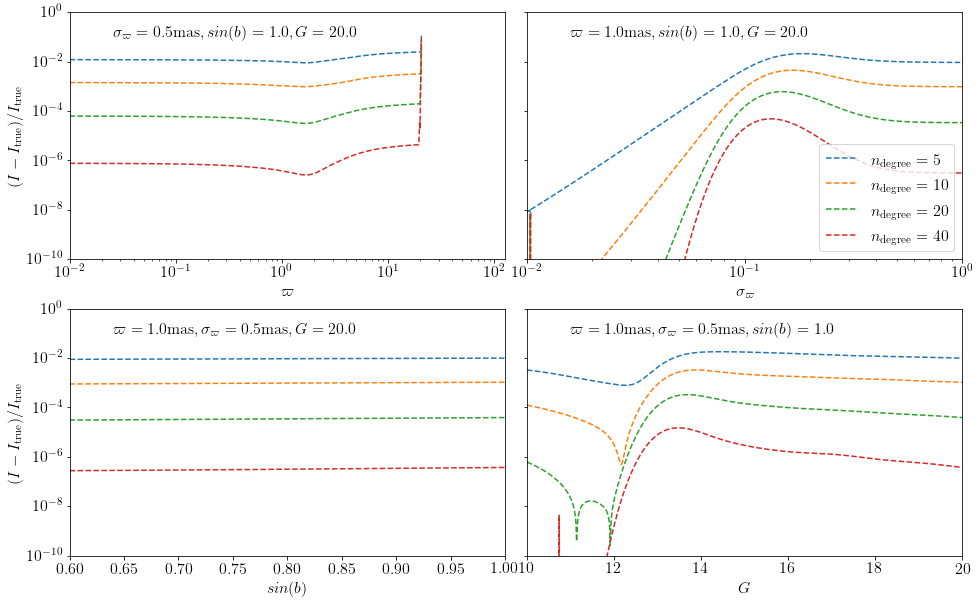

In [29]:
fig, axes = plt.subplots(2,2,figsize=(16,10), sharey=True)

plt.sca(axes[0,0])

store = sample_args[0]
sample_args[0] = np.logspace(-2,2.1,n_obj)
p_gh, p_trap, p_quad = cmpt_integral(sample_args, kwparams, kwargs, degrees=degrees, n_grid=5000, component=component)

for ideg in range(len(degrees)):
    y = np.abs(p_gh[ideg]-p_quad)/p_quad
    plt.plot(sample_args[0], y, label=r'$n_\mathrm{degree} = %d$' % degrees[ideg],
            linestyle='--')
plt.xscale('log'); plt.yscale('log'); plt.xlim(sample_args[0][0], sample_args[0][-1])
#plt.legend(loc='lower left')
plt.xlabel(r'$\varpi$'); plt.ylabel(r'$(I - I_\mathrm{true})/I_\mathrm{true}$')

sample_args[0] = store


plt.sca(axes[0,1])

store = sample_args[1]
sample_args[1] = np.logspace(-2,0.,n_obj)
p_gh, p_trap, p_quad = cmpt_integral(sample_args, kwparams, kwargs, degrees=degrees, n_grid=5000, component=component)

for ideg in range(len(degrees)):
    y = np.abs(p_gh[ideg]-p_quad)/p_quad
    plt.plot(sample_args[1], y, label=r'$n_\mathrm{degree} = %d$' % degrees[ideg],
            linestyle='--')
plt.xscale('log'); plt.yscale('log'); plt.xlim(sample_args[1][0], sample_args[1][-1])
plt.legend(loc='lower right')
plt.xlabel(r'$\sigma_\varpi$'); #plt.ylabel(r'$(I - I_\mathrm{true})/I_\mathrm{true}$')

sample_args[1] = store


plt.sca(axes[1,0])

store = sample_args[2]
sample_args[2] = np.linspace(0.6,1,n_obj)
p_gh, p_trap, p_quad = cmpt_integral(sample_args, kwparams, kwargs, degrees=degrees, n_grid=5000, component=component)

for ideg in range(len(degrees)):
    y = np.abs(p_gh[ideg]-p_quad)/p_quad
    plt.plot(sample_args[2], y, label=r'$n_\mathrm{degree} = %d$' % degrees[ideg],
            linestyle='--')
plt.yscale('log'); plt.xlim(sample_args[2][0], sample_args[2][-1])
plt.xlabel(r'$sin(b)$'); plt.ylabel(r'$(I - I_\mathrm{true})/I_\mathrm{true}$')

sample_args[2] = store


plt.sca(axes[1,1])

store = sample_args[3]
sample_args[3] = np.linspace(10,20,n_obj)
p_gh, p_trap, p_quad = cmpt_integral(sample_args, kwparams, kwargs, degrees=degrees, n_grid=5000, component=component)

for ideg in range(len(degrees)):
    y = np.abs(p_gh[ideg]-p_quad)/p_quad
    plt.plot(sample_args[3], y, label=r'$n_\mathrm{degree} = %d$' % degrees[ideg],
            linestyle='--')
plt.yscale('log'); plt.xlim(sample_args[3][0], sample_args[3][-1])
plt.xlabel(r'$G$'); #plt.ylabel(r'$(I - I_\mathrm{true})/I_\mathrm{true}$')

sample_args[3] = store



plt.ylim(1e-10, 1e0)
ymin, ymax = axes[0,0].get_ylim()

xmin, xmax = axes[0,0].get_xlim()
masstr = "\mathrm{mas}"
axes[0,0].text((xmax**0.1 * xmin**0.9), (ymax**0.9 * ymin**0.1),
         fr"$\sigma_\varpi={sample_args[1][0]}{masstr}, sin(b)={sample_args[2][0]}, G={sample_args[3][0]}$")

xmin, xmax = axes[0,1].get_xlim()
axes[0,1].text((xmax**0.1 * xmin**0.9), (ymax**0.9 * ymin**0.1),
         fr"$\varpi={sample_args[0][0]}{masstr}, sin(b)={sample_args[2][0]}, G={sample_args[3][0]}$")

xmin, xmax = axes[1,0].get_xlim()
axes[1,0].text(xmin*0.9+xmax*0.1, (ymax**0.9 * ymin**0.1),
         fr"$\varpi={sample_args[0][0]}{masstr}, \sigma_\varpi={sample_args[1][0]}{masstr}, G={sample_args[3][0]}$")

xmin, xmax = axes[1,1].get_xlim()
axes[1,1].text(xmin*0.9+xmax*0.1, (ymax**0.9 * ymin**0.1),
         fr"$\varpi={sample_args[0][0]}{masstr}, \sigma_\varpi={sample_args[1][0]}{masstr}, sin(b)={sample_args[2][0]}$")


plt.subplots_adjust(wspace=0.05)

plt.savefig(f'integral_figs/{file}_{size}_{run_id:03d}_truepars_thindisk-vs-quad.png', bbox_inches='tight')

In [30]:
cmpt = 1; component='exp'

kwargs = dict({key: model_sf_perr.fixed_pars[cmpt][key] for key in ['Mms', 'Mms1', 'Mms2', 'Mto']}, 
              **{'Mx':model_sf_perr.fixed_pars['Mx'],
                 'R0':model_sf_perr.fixed_pars['R0']})

kwparams = dict({['hz','fD', 'alpha3'][i]:true_params[4*cmpt + 1 + i] for i in range(3)},
               **{['alpha1','alpha2'][i]:true_params[12 + i] for i in range(2)})

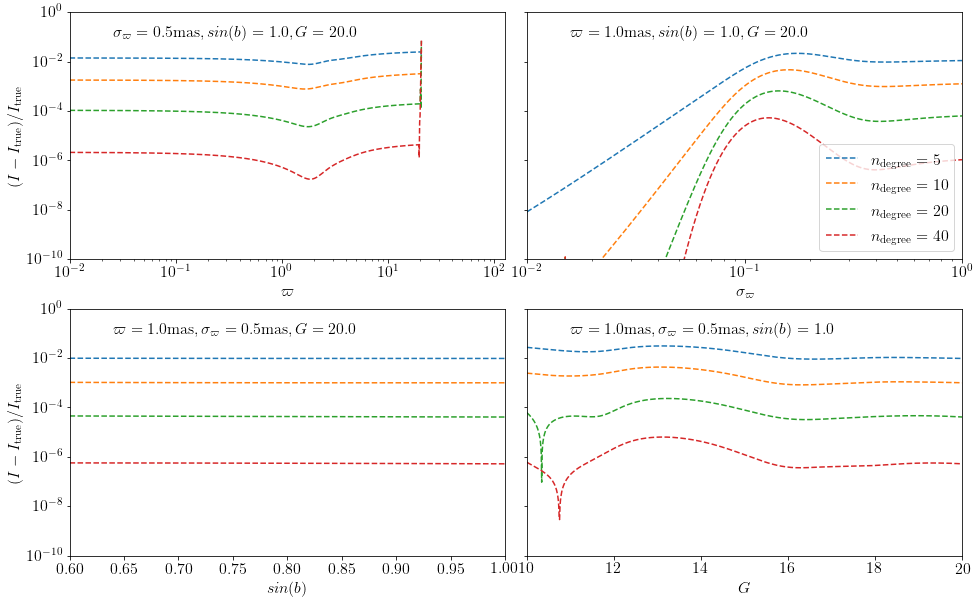

In [32]:
fig, axes = plt.subplots(2,2,figsize=(16,10), sharey=True)

plt.sca(axes[0,0])

store = sample_args[0]
sample_args[0] = np.logspace(-2,2.1,n_obj)
p_gh, p_trap, p_quad = cmpt_integral(sample_args, kwparams, kwargs, degrees=degrees, n_grid=5000, component=component)

for ideg in range(len(degrees)):
    y = np.abs(p_gh[ideg]-p_quad)/p_quad
    plt.plot(sample_args[0], y, label=r'$n_\mathrm{degree} = %d$' % degrees[ideg],
            linestyle='--')
plt.xscale('log'); plt.yscale('log'); plt.xlim(sample_args[0][0], sample_args[0][-1])
#plt.legend(loc='lower left')
plt.xlabel(r'$\varpi$'); plt.ylabel(r'$(I - I_\mathrm{true})/I_\mathrm{true}$')

sample_args[0] = store


plt.sca(axes[0,1])

store = sample_args[1]
sample_args[1] = np.logspace(-2,0.,n_obj)
p_gh, p_trap, p_quad = cmpt_integral(sample_args, kwparams, kwargs, degrees=degrees, n_grid=5000, component=component)

for ideg in range(len(degrees)):
    y = np.abs(p_gh[ideg]-p_quad)/p_quad
    plt.plot(sample_args[1], y, label=r'$n_\mathrm{degree} = %d$' % degrees[ideg],
            linestyle='--')
plt.xscale('log'); plt.yscale('log'); plt.xlim(sample_args[1][0], sample_args[1][-1])
plt.legend(loc='lower right')
plt.xlabel(r'$\sigma_\varpi$'); #plt.ylabel(r'$(I - I_\mathrm{true})/I_\mathrm{true}$')

sample_args[1] = store


plt.sca(axes[1,0])

store = sample_args[2]
sample_args[2] = np.linspace(0.6,1,n_obj)
p_gh, p_trap, p_quad = cmpt_integral(sample_args, kwparams, kwargs, degrees=degrees, n_grid=5000, component=component)

for ideg in range(len(degrees)):
    y = np.abs(p_gh[ideg]-p_quad)/p_quad
    plt.plot(sample_args[2], y, label=r'$n_\mathrm{degree} = %d$' % degrees[ideg],
            linestyle='--')
plt.yscale('log'); plt.xlim(sample_args[2][0], sample_args[2][-1])
plt.xlabel(r'$sin(b)$'); plt.ylabel(r'$(I - I_\mathrm{true})/I_\mathrm{true}$')

sample_args[2] = store


plt.sca(axes[1,1])

store = sample_args[3]
sample_args[3] = np.linspace(10,20,n_obj)
p_gh, p_trap, p_quad = cmpt_integral(sample_args, kwparams, kwargs, degrees=degrees, n_grid=5000, component=component)

for ideg in range(len(degrees)):
    y = np.abs(p_gh[ideg]-p_quad)/p_quad
    plt.plot(sample_args[3], y, label=r'$n_\mathrm{degree} = %d$' % degrees[ideg],
            linestyle='--')
plt.yscale('log'); plt.xlim(sample_args[3][0], sample_args[3][-1])
plt.xlabel(r'$G$'); #plt.ylabel(r'$(I - I_\mathrm{true})/I_\mathrm{true}$')

sample_args[3] = store



plt.ylim(1e-10, 1e0)
ymin, ymax = axes[0,0].get_ylim()

xmin, xmax = axes[0,0].get_xlim()
masstr = "\mathrm{mas}"
axes[0,0].text((xmax**0.1 * xmin**0.9), (ymax**0.9 * ymin**0.1),
         fr"$\sigma_\varpi={sample_args[1][0]}{masstr}, sin(b)={sample_args[2][0]}, G={sample_args[3][0]}$")

xmin, xmax = axes[0,1].get_xlim()
axes[0,1].text((xmax**0.1 * xmin**0.9), (ymax**0.9 * ymin**0.1),
         fr"$\varpi={sample_args[0][0]}{masstr}, sin(b)={sample_args[2][0]}, G={sample_args[3][0]}$")

xmin, xmax = axes[1,0].get_xlim()
axes[1,0].text(xmin*0.9+xmax*0.1, (ymax**0.9 * ymin**0.1),
         fr"$\varpi={sample_args[0][0]}{masstr}, \sigma_\varpi={sample_args[1][0]}{masstr}, G={sample_args[3][0]}$")

xmin, xmax = axes[1,1].get_xlim()
axes[1,1].text(xmin*0.9+xmax*0.1, (ymax**0.9 * ymin**0.1),
         fr"$\varpi={sample_args[0][0]}{masstr}, \sigma_\varpi={sample_args[1][0]}{masstr}, sin(b)={sample_args[2][0]}$")


plt.subplots_adjust(wspace=0.05)

plt.savefig(f'integral_figs/{file}_{size}_{run_id:03d}_truepars_thickdisk-vs-quad.png', bbox_inches='tight')

In [33]:
cmpt = 2; component='halo'

kwargs = dict({key: model_sf_perr.fixed_pars[cmpt][key] for key in ['Mms', 'Mms1', 'Mms2', 'Mto']}, 
              **{'Mx':model_sf_perr.fixed_pars['Mx'],
                 'R0':model_sf_perr.fixed_pars['R0']})

kwparams = dict({['hz','fD', 'alpha3'][i]:true_params[4*cmpt + 1 + i] for i in range(3)},
               **{['alpha1','alpha2'][i]:true_params[12 + i] for i in range(2)})

# kwparams = dict({['hz','fD', 'alpha3'][i]:bad_params[4*cmpt + 1 + i] for i in range(3)},
#                **{['alpha1','alpha2'][i]:bad_params[12 + i] for i in range(2)})

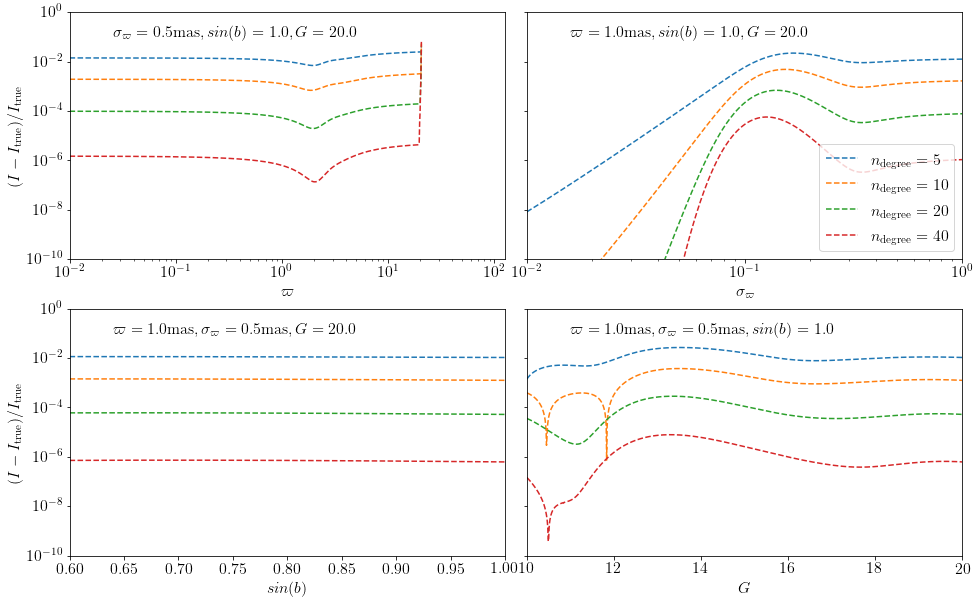

In [34]:
fig, axes = plt.subplots(2,2,figsize=(16,10), sharey=True)

plt.sca(axes[0,0])

store = sample_args[0]
sample_args[0] = np.logspace(-2,2.1,n_obj)
p_gh, p_trap, p_quad = cmpt_integral(sample_args, kwparams, kwargs, degrees=degrees, n_grid=5000, component=component)

for ideg in range(len(degrees)):
    y = np.abs(p_gh[ideg]-p_quad)/p_quad
    plt.plot(sample_args[0], y, label=r'$n_\mathrm{degree} = %d$' % degrees[ideg],
            linestyle='--')
plt.xscale('log'); plt.yscale('log'); plt.xlim(sample_args[0][0], sample_args[0][-1])
#plt.legend(loc='lower left')
plt.xlabel(r'$\varpi$'); plt.ylabel(r'$(I - I_\mathrm{true})/I_\mathrm{true}$')

sample_args[0] = store


plt.sca(axes[0,1])

store = sample_args[1]
sample_args[1] = np.logspace(-2,0.,n_obj)
p_gh, p_trap, p_quad = cmpt_integral(sample_args, kwparams, kwargs, degrees=degrees, n_grid=5000, component=component)

for ideg in range(len(degrees)):
    y = np.abs(p_gh[ideg]-p_quad)/p_quad
    plt.plot(sample_args[1], y, label=r'$n_\mathrm{degree} = %d$' % degrees[ideg],
            linestyle='--')
plt.xscale('log'); plt.yscale('log'); plt.xlim(sample_args[1][0], sample_args[1][-1])
plt.legend(loc='lower right')
plt.xlabel(r'$\sigma_\varpi$'); #plt.ylabel(r'$(I - I_\mathrm{true})/I_\mathrm{true}$')

sample_args[1] = store


plt.sca(axes[1,0])

store = sample_args[2]
sample_args[2] = np.linspace(0.6,1,n_obj)
p_gh, p_trap, p_quad = cmpt_integral(sample_args, kwparams, kwargs, degrees=degrees, n_grid=5000, component=component)

for ideg in range(len(degrees)):
    y = np.abs(p_gh[ideg]-p_quad)/p_quad
    plt.plot(sample_args[2], y, label=r'$n_\mathrm{degree} = %d$' % degrees[ideg],
            linestyle='--')
plt.yscale('log'); plt.xlim(sample_args[2][0], sample_args[2][-1])
plt.xlabel(r'$sin(b)$'); plt.ylabel(r'$(I - I_\mathrm{true})/I_\mathrm{true}$')

sample_args[2] = store


plt.sca(axes[1,1])

store = sample_args[3]
sample_args[3] = np.linspace(10,20,n_obj)
p_gh, p_trap, p_quad = cmpt_integral(sample_args, kwparams, kwargs, degrees=degrees, n_grid=5000, component=component)

for ideg in range(len(degrees)):
    y = np.abs(p_gh[ideg]-p_quad)/p_quad
    plt.plot(sample_args[3], y, label=r'$n_\mathrm{degree} = %d$' % degrees[ideg],
            linestyle='--')
plt.yscale('log'); plt.xlim(sample_args[3][0], sample_args[3][-1])
plt.xlabel(r'$G$'); #plt.ylabel(r'$(I - I_\mathrm{true})/I_\mathrm{true}$')

sample_args[3] = store



plt.ylim(1e-10, 1e0)
ymin, ymax = axes[0,0].get_ylim()

xmin, xmax = axes[0,0].get_xlim()
masstr = "\mathrm{mas}"
axes[0,0].text((xmax**0.1 * xmin**0.9), (ymax**0.9 * ymin**0.1),
         fr"$\sigma_\varpi={sample_args[1][0]}{masstr}, sin(b)={sample_args[2][0]}, G={sample_args[3][0]}$")

xmin, xmax = axes[0,1].get_xlim()
axes[0,1].text((xmax**0.1 * xmin**0.9), (ymax**0.9 * ymin**0.1),
         fr"$\varpi={sample_args[0][0]}{masstr}, sin(b)={sample_args[2][0]}, G={sample_args[3][0]}$")

xmin, xmax = axes[1,0].get_xlim()
axes[1,0].text(xmin*0.9+xmax*0.1, (ymax**0.9 * ymin**0.1),
         fr"$\varpi={sample_args[0][0]}{masstr}, \sigma_\varpi={sample_args[1][0]}{masstr}, G={sample_args[3][0]}$")

xmin, xmax = axes[1,1].get_xlim()
axes[1,1].text(xmin*0.9+xmax*0.1, (ymax**0.9 * ymin**0.1),
         fr"$\varpi={sample_args[0][0]}{masstr}, \sigma_\varpi={sample_args[1][0]}{masstr}, sin(b)={sample_args[2][0]}$")


plt.subplots_adjust(wspace=0.05)

plt.savefig(f'integral_figs/{file}_{size}_{run_id:03d}_truepars_halo-vs-quad.png', bbox_inches='tight')